In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
# from scipy.fftpack import fft
from numpy.fft import rfft, rfftfreq

In [2]:
file = 'data/salesdaily.csv'
df = pd.read_csv(file)

### Exploratory Data Analysis (EDA)

In [5]:
df.shape

(2106, 13)

The dataset includes 2106 observations and 13 columns. <br>
Out of which 5 are time marks and rest 6 are variables that represent the number of sales in units for several Anatomical Therapeutic Chemical Classification (ATC)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
datum           2106 non-null object
M01AB           2106 non-null float64
M01AE           2106 non-null float64
N02BA           2106 non-null float64
N02BE           2106 non-null float64
N05B            2106 non-null float64
N05C            2106 non-null float64
R03             2106 non-null float64
R06             2106 non-null float64
Year            2106 non-null int64
Month           2106 non-null int64
Hour            2106 non-null int64
Weekday Name    2106 non-null object
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


So, there is perfectly rafinated data from Kaggle comprises two type of variables: float64, int64 and no one NaN/missing value. <br>
There is strong likelihood that you never meet so clear data from the real world.

In [5]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use

In [6]:
df.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000
mean,5.033683,3.895830,3.880441,29.917095,8.853627,0.593522,5.512262,2.900198,2016.401235,6.344255,275.945869
std,2.737579,2.133337,2.384010,15.590966,5.605605,1.092988,6.428736,2.415816,1.665060,3.386954,1.970547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000,190.000000
25%,3.000000,2.340000,2.000000,19.000000,5.000000,0.000000,1.000000,1.000000,2015.000000,3.000000,276.000000
50%,4.990000,3.670000,3.500000,26.900000,8.000000,0.000000,4.000000,2.000000,2016.000000,6.000000,276.000000
75%,6.670000,5.138000,5.200000,38.300000,12.000000,1.000000,8.000000,4.000000,2018.000000,9.000000,276.000000
max,17.340000,14.463000,16.000000,161.000000,54.833333,9.000000,45.000000,15.000000,2019.000000,12.000000,276.000000


<br>You can see that median and mean values (50%) are close to each other which means no many outliers. Otherwise, there are exist, to see that look at the range between 75th %tile and max values. </br>
<br> Let's figure it out how many outliers we have and where they are.</br>

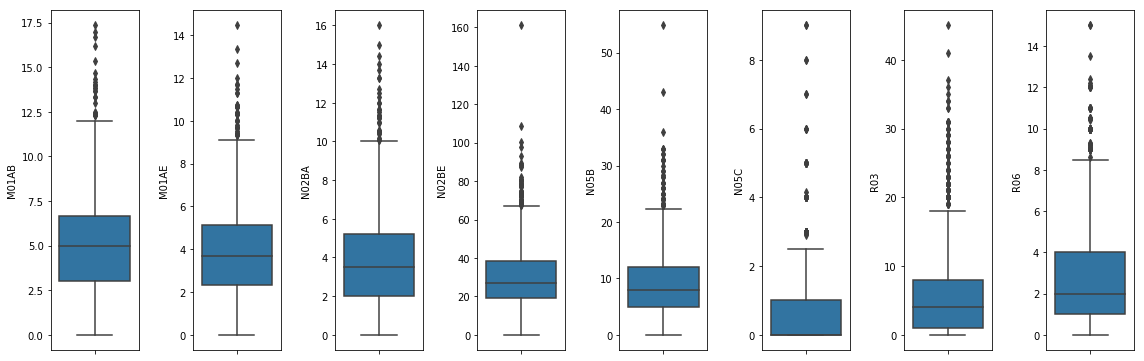

In [6]:
columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

number_of_columns = len(columns)
plt.figure(figsize=(2*number_of_columns,10))
for category in range(0,number_of_columns):
    plt.subplot(2 ,number_of_columns ,category+1)
    sns.boxplot(df[columns[category]], orient='v')
    plt.tight_layout()

Look at that! All of them includes outliers.<br>
In accordance with statistical terms, outliers are defined as how values those out of 3 IQR.

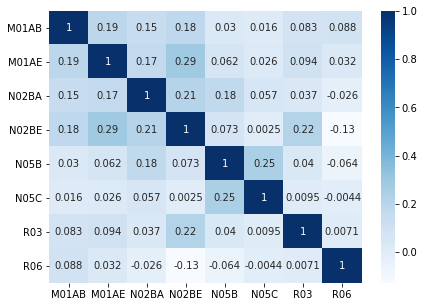

In [10]:
# demonstration of the correlation matrix for categories above
corr = df[cols].corr()
plt.figure(figsize = (7,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, cmap='Blues');

As part of exploratory data analysis sometimes incredibly useful to look at correlation matrix to future models tuning or further data exploration. <br>
On the graph above dark shades represents positive correlation while lighter shades negative.
If you, for instance, would like to use linear regression, you have to consider removing correlated variables to improve forecast accuracy. <br>
In our case, we can see a weak correlation between related categories (N05B, N05C, and N02BA, N02BE) and an interesting association between M01AE, N02BA codes. Defining the reasons for that could be the goal of further analysis.

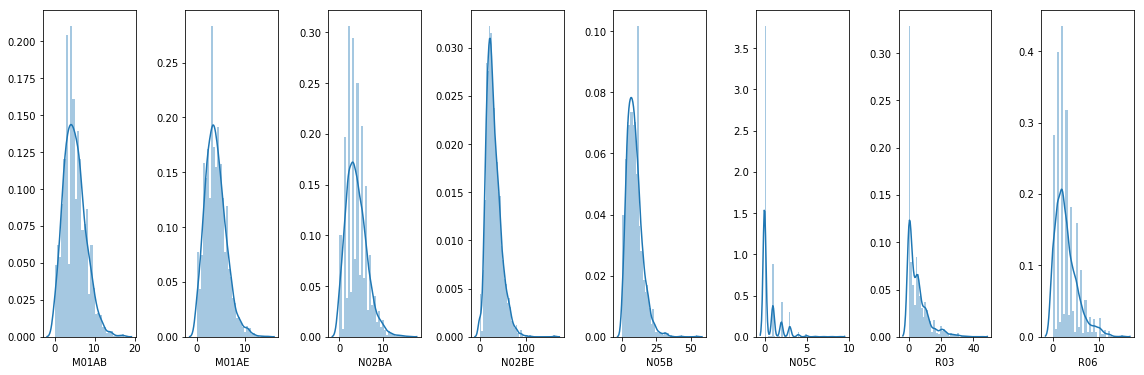

In [53]:
plt.figure(figsize=(2*number_of_columns,10))
for category in range(0,number_of_columns):
    plt.subplot(2 ,number_of_columns ,category+1)
    sns.distplot(df[columns[category]], kde=True)
    plt.tight_layout()

Here we see how data is distributed and what are most popular values for each independent categories. <br>
Also, we can see M01AB and M01AE seems like normally distributed. In the same time remaining codes are left skewed.

#### So, let's build up a time series prediction models

In [3]:
#ATC codes by types of category
atc_codes = {'Antirheumatic' : ['M01AB','M01AE'],
             'Analgesics' : ['N02BA','N02BE'],
             'Psycholeptics' : ['N05C','N05B'],
             'Airway diseases': ['R03'],
             'Antihistamines': ['R06']}

In [4]:
#create a function which will help us to explore a sales dynamic
def create_charts(data, markets, title, index, freq, DF=None):
    
    'Creates line chart with time defined frequency by markets'
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    for codes in markets:
        ax.set_title('{} market'.format(title))
        index = data[codes].resample(freq).sum().index
        plt.plot(index, data[codes].resample(freq).sum())
        register_matplotlib_converters()
        plt.legend();

In [5]:
#convert a column with dates to pandas daytime format
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index('datum')

#### Now we are ready to observe how sales changes

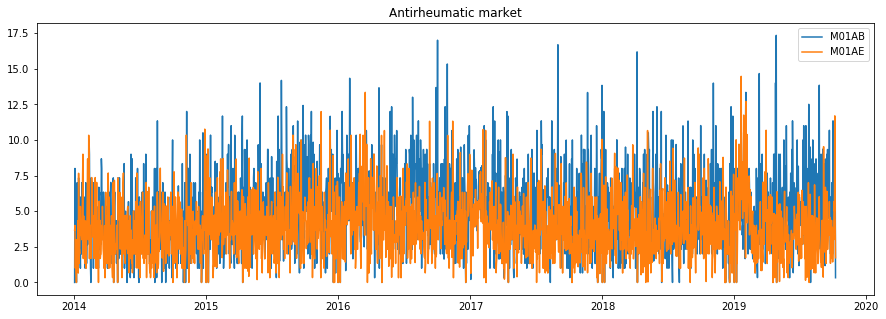

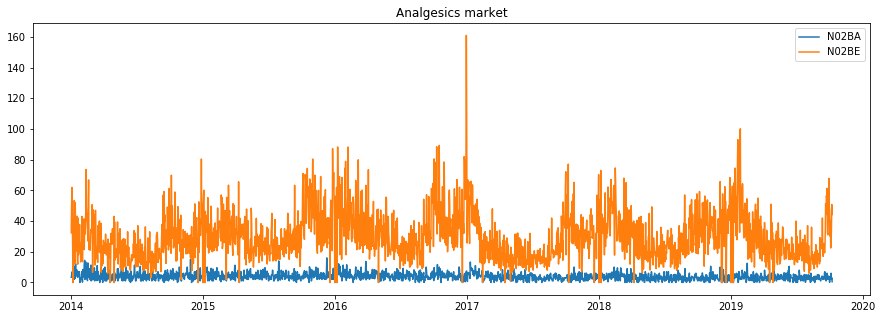

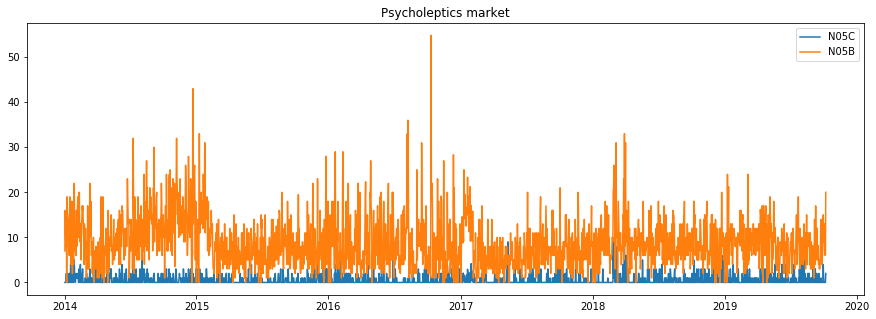

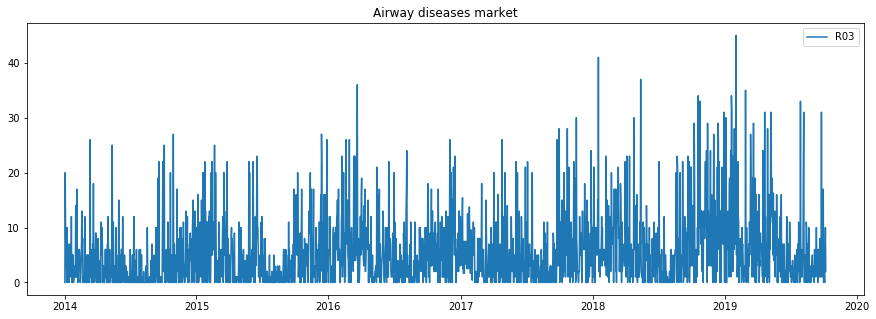

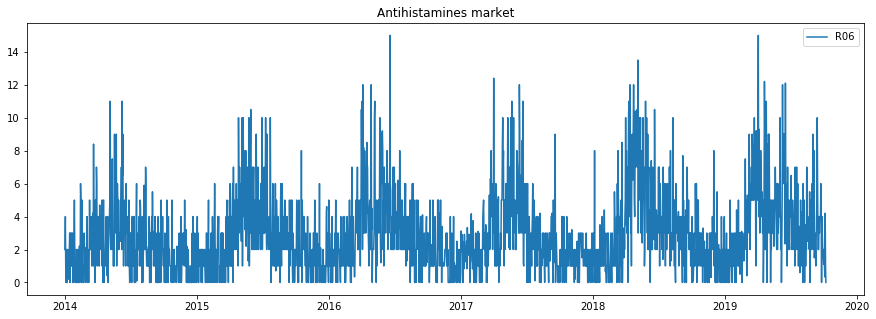

In [127]:
#use predefined the function above to explore sales dynamic
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.index, 'D', DF=True)

Easy to see a clear seasonality of sales of antihistamines and analgesics products.<br>
Also, on first sight, data looks quite stationary. <br>
Let's determine is a time series is stationary or not by applying the Dickey-Fuller test

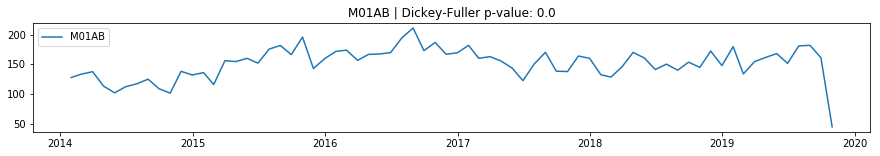

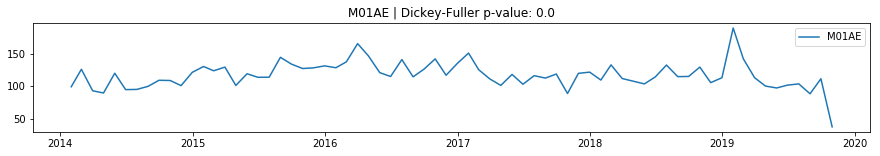

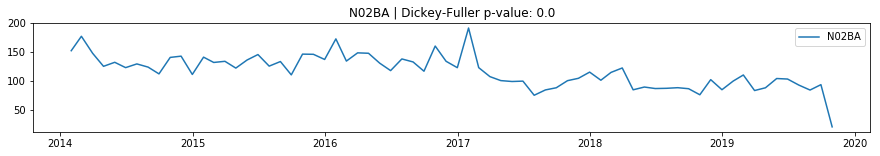

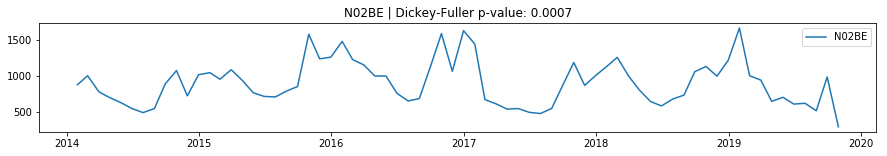

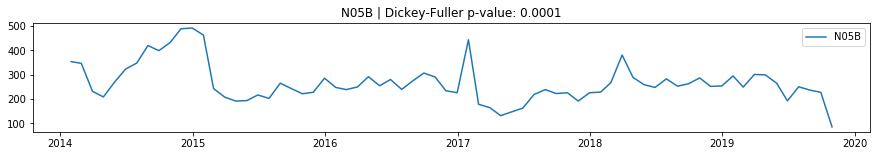

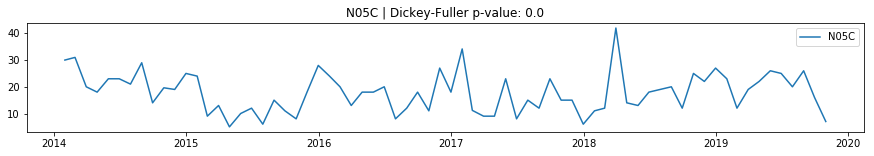

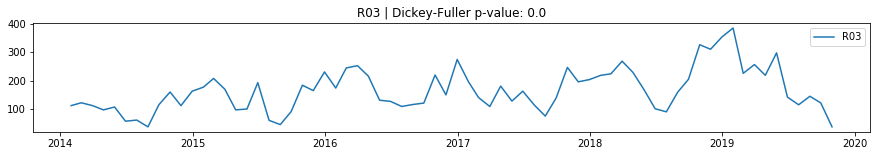

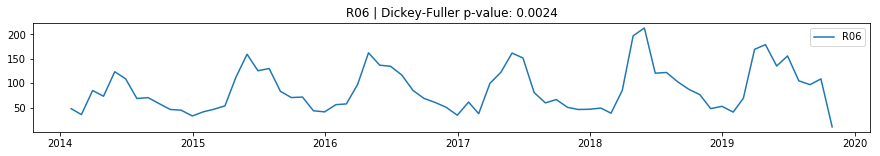

In [129]:
for code in columns:
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,2))
    ax.set_title('{} | Dickey-Fuller p-value: {}'.format(code ,round(adfuller(df[code])[1], 4)))
    index = df[code].resample('M').sum().index
    plt.plot(index, df[code].resample('M').sum())
    register_matplotlib_converters()
    plt.legend();

<br> How you can see we have changed a frequency of the data from daily to monthly </br>
<br> That made data is much more readable and we can see that all of the markets except one have a seasonality</br>
<br> At the same time, you can see how increased the number of sales during the 2015 year on psycholeptics market and sharply declined then </br>
<br> Sales of the airway disease market except seasonality includes an improving trend</br>
<br> By the way, you may have noticed in the title of the values of the chart of the p-value of the Dickey-Fuller test: </br>
- when p-value > 0, and the data is not stationary.
- otherwise, p-value = 0, the null hypothesis is rejected, and the process is considered to be stationary.</br>

In [110]:
def DF_test(data):
    
    'Prints the Dickey-Fuller test'
    
    statistics = adfuller(data)
    print('DF Statistic: {}'.format(round(statistics[0], 2)))
    print('p-value: {}'.format(round(statistics[1], 4)))
    print('Critical Values:')
    for key, value in statistics[4].items():
        print('\t{}: {}'.format(key, round(value, 2)))

In [114]:
DF_test(df['R03'])

DF Statistic: -5.13
p-value: 0.0
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


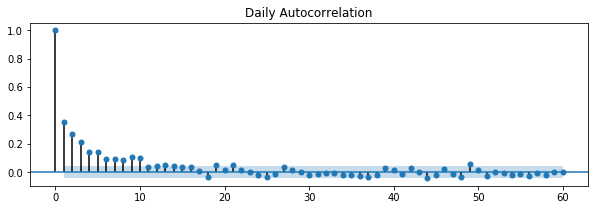

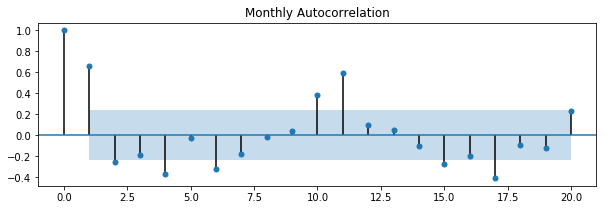

In [148]:
#look at autocorrelation
fig, ax1 = plt.subplots(figsize=(10, 3))
fig, ax2 = plt.subplots(figsize=(10, 3))
daily_autocorr = plot_pacf(df['R06'], lags=60, title='Daily Autocorrelation', ax=ax1)
monthly_autocorr = plot_pacf(df['R06'].resample('M').sum(), lags=20, title='Monthly Autocorrelation', ax=ax2)

<br>To demonstrate how works the .plot_pacf function we took data with seasonality. </br>
<br>If autocorrelation values are close to 0, it is mean that values between lagged observations are not correlated with one another. At the same time, partial autocorrelations with values close to 1 or -1 demonstrate that there exist strong positive or negative correlations between the lagged observations of the time series.</br>
<br>The blue shaded regions indicate borders of the confidence intervals. If partial autocorrelation values are beyond this confidence interval regions, then you can assume that the observed partial autocorrelation values are statistically significant.</br>

Pay your attention that daily values highly correlated with nearest observations, otherwise on the monthly chart you can notice a significant correlation with the same month last year.

In [60]:
freq = rfftfreq(len(df['R03'].resample('M').sum()), d = 1/12 )
rffabs = abs(rfft(df['R03'].resample('M').sum()))

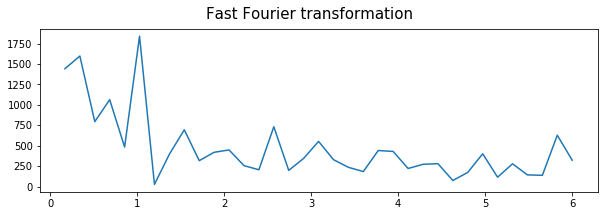

In [61]:
fig = plt.figure(figsize = (10,3))
fig.suptitle('Fast Fourier transformation', fontsize=15)
plt.plot(freq[1:], rffabs[1:]);

### Train

In [162]:
#let's dedicate the Analgesics market for the further steps
data = df[atc_codes['Analgesics']].copy()
data = data.set_index(df.index)

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 2 columns):
N02BA    2106 non-null float64
N02BE    2106 non-null float64
dtypes: float64(2)
memory usage: 49.4 KB


In [164]:
#combine ATC codes related to the same market in one
data['volume_sales'] = data['N02BA'] + data['N02BE']
data = data.drop(columns=['N02BA', 'N02BE'])

In [169]:
#split data for 2 independent groups. The first one we will use to training models and second one as test
train_data = data['01/01/2017':'04/30/2019'].copy()
test_data = data['05/1/2019':].copy()

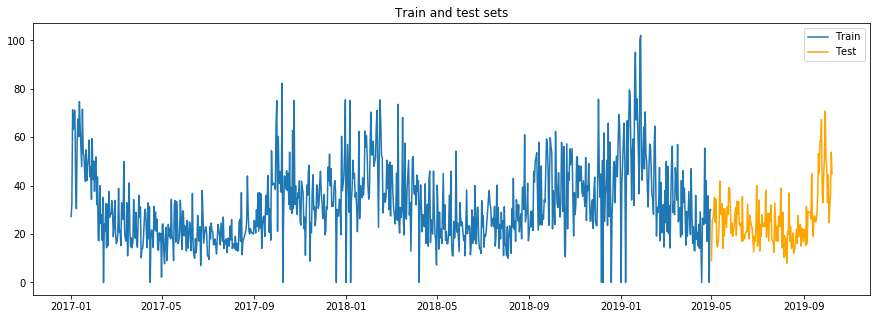

In [170]:
#let's looks on those
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['volume_sales'], label='Train')
plt.plot(test_data.index, test_data['volume_sales'], color='orange', label='Test')
plt.legend()
plt.title('Train and test sets')
register_matplotlib_converters()
plt.show()

Below we have to create some functions to generate features that we will use as predictors inside our's models. <br>
Pay your attention there are functions which return dummy features for daytime values and one to standardize has made figures

### Initial preprocessing and feature generation

How we remember the time series which has been selected is stationary, but usually you will work with non-stationary data.
So, for the purpose of this demonstration, we apply Box-Cox transformation

In [196]:
# transform training data & save lambda value
train, fitted_lambda = stats.boxcox(train_data + 1) #add 1 to handle zero values
df_train = pd.DataFrame(train, index=train_data.index, columns=['volume_sales'])


# use lambda value to transform test data
test = stats.boxcox(test_data, fitted_lambda)
df_test = pd.DataFrame(test, index=test_data.index, columns=['volume_sales'])

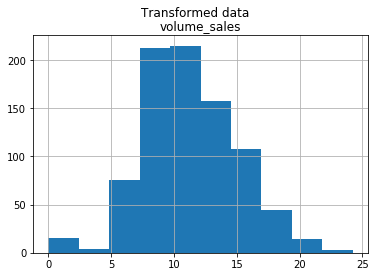

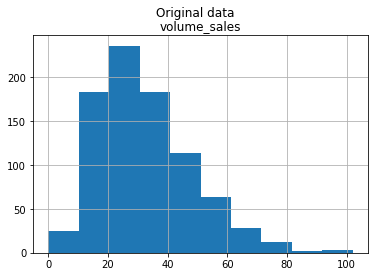

In [197]:
df_train.hist()
plt.suptitle("Transformed data")
train_data.hist()
plt.suptitle("Original data");

In [198]:
def linreg(X):
    
    n = X.shape[0]
    x = np.concatenate((np.ones(n),
                        np.arange(n)),
                      ).reshape(2, n).T
    
    y = X.reshape(-1,1)
    theta = np.linalg.pinv(x.dot(x.T)).dot(x).T.dot(y)

    return np.array([[1, n]]).dot(theta)

In [199]:
def create_features(data, lags_list):
    
    'create predictors for the model'
    
    X = pd.DataFrame(data.values.ravel(), index=data.index, columns=['y'])
    
    for window in lags_list:
        X['lin_reg_{}'.format(window)] = X['y'].shift(1).rolling(window=window).apply(linreg, raw=True)
        X['shift_{}'.format(window)] = X['y'].shift(window)
        X['diff_{}'.format(window)] = X['y'].shift(1).diff(window)
        X['rolling_mean_{}'.format(window)] = X['y'].shift(1).rolling(window=window).mean()
        X['rolling_max_{}'.format(window)] = X['y'].shift(1).rolling(window=window).max()
        X['rolling_std_{}'.format(window)] = X['y'].shift(1).rolling(window=window).std()
        X['rolling_min_{}'.format(window)] = X['y'].shift(1).rolling(window=window).min()
        
    X = X.fillna(np.nanmedian(X))
    
    return X.drop('y', axis=1)

In [200]:
def create_dummies(data):
    
    'return dataset with dummy variables of the day'
    
    X = pd.DataFrame({'day_of_week' : data.index.weekday_name}, data.index)
    days = pd.get_dummies(X['day_of_week'])
    result = pd.concat([data, days], axis=1, sort=False)
    
    return result

In [249]:
def scaler(data):
    
    'apply the sklearn MinMaxScaler'
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    result = pd.DataFrame(scaled, columns=[data.columns], index=data.index)
    
    return result

In [225]:
lags = [2,7,14]
X_train = scaler(create_dummies(create_features(df_train, lags)))

### Train

In [204]:
#define models and their initial state
model_ridge = Ridge()
model_lasso = Lasso()
model_tree = DecisionTreeRegressor()
model_forest = RandomForestRegressor()
models = {'forest': model_forest,
          'lasso': model_lasso,
          'ridge': model_ridge,
          'tree': model_tree}

In [205]:
def train(X, actual, model, n_splits=10):
    
    'trains models and apply cross-validation for the time series data'
    
    cv = TimeSeriesSplit(n_splits=n_splits)
    y = []
    i = 0 

    for train, test in cv.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = actual[train], actual[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if i == 0:
            y.extend(model.predict(X_train))
        i+=1
        y.extend(y_pred)
        
    return y

In [206]:
df = pd.DataFrame()
for model in models.items():
    df[model[0]] = train(X_train, df_train.values.ravel(), model[1])

In [207]:
def model_to_chart(y, y_pred, model_name, index):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    ax.set_title('Model:{}, MAE = {:.3f}'.format(model_name, mean_absolute_error(y, y_pred)))
    plt.plot(index, y, label='True')
    plt.plot(index, y_pred, label='Predicted')
    plt.plot(index, y - y_pred, label='error', alpha=.3)
    plt.legend()
    register_matplotlib_converters();

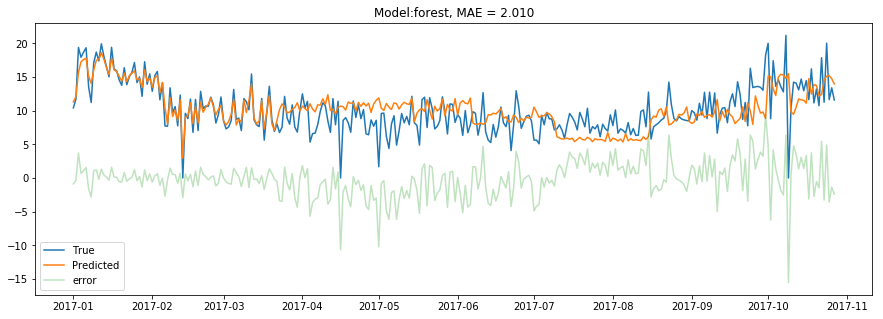

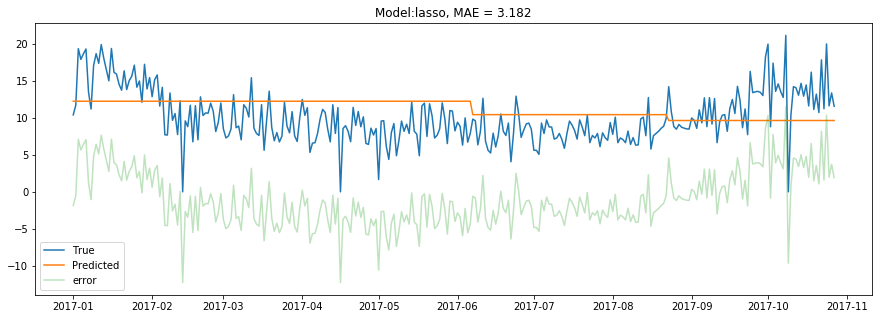

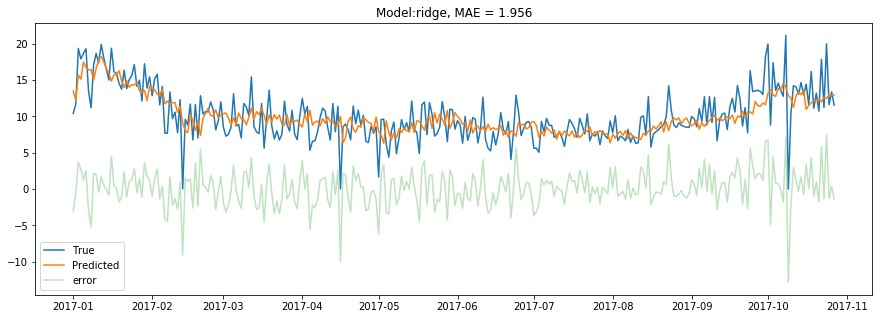

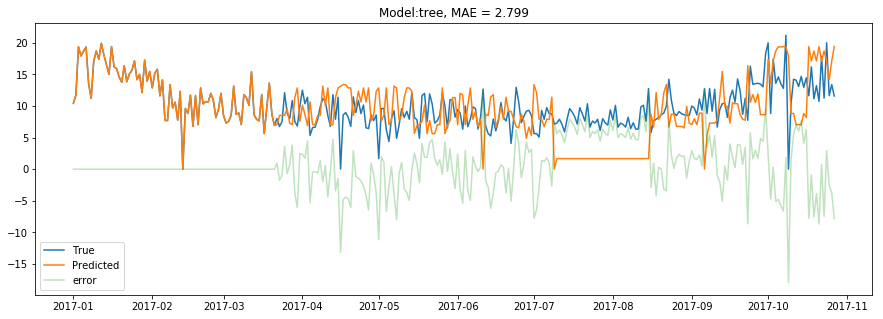

In [208]:
for model in models.items():
    model_to_chart(y=df_train[:300].values.ravel(), 
                y_pred= df[:300][model[0]].values, 
                index = df_train[:300].index, 
                model_name=model[0])

### Test

In [209]:
def create_dates(data, n_steps_prediction):
    
    'creates 1 time step from the latest date'
    
    start_date = data.index[-1] + pd.DateOffset(1) #defines the latest date
    new_date = pd.date_range(start_date, periods=n_steps_prediction) #create dataset with dates
    
    return data.append(pd.DataFrame(index=new_date), sort=True) #add new values to the dateset

In [229]:
def forecaster(models, data, n_steps, lags_list):
    
    'predicts new values on the base of already predicted''
    
    df = create_dates(data, n_steps) #this line creates new dates
    
    for model in models.items(): #iterate over the models
        
        df[model[0]] = df.values[:,0] #provide original values to generate initial features

        for i in range(0, n_steps-1):
            x_features = scaler(create_dummies(create_features(df[model[0]], lags_list=lags_list))) #here we generate predictors and scale them
            y_pred = np.round(model[1].predict(x_features.iloc[-n_steps+i:-n_steps+i+1]), 2) #predict new value
            
            df[model[0]].iloc[-n_steps+i] = y_pred #this line adds predicted value into the end of dataset for the specific model
        
    return df

Pay your attention, we are going to make predictions 30 time steps ahead. Also, important to remember that the features generation function uses historical data. For this reason, we have to give the 14 time steps from the train data to generate initial features

In [244]:
predicted_values = forecaster(models = models, data=df_train[-14:], n_steps=30, lags_list=lags)

In [234]:
predicted_values.drop(axis=1, columns='volume_sales', inplace=True)

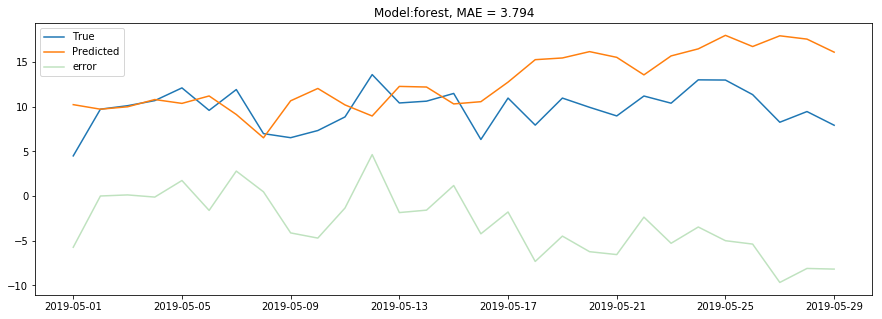

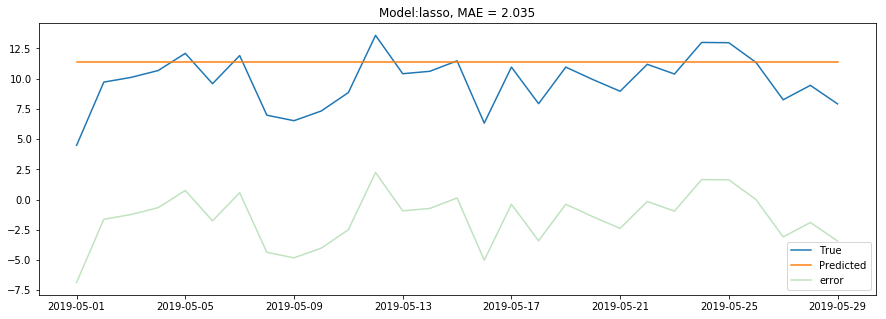

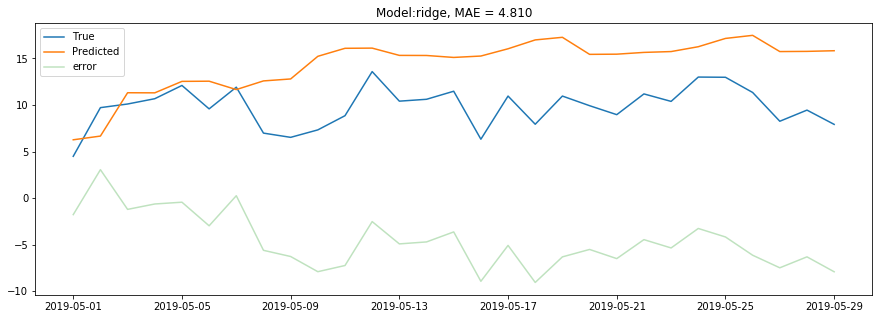

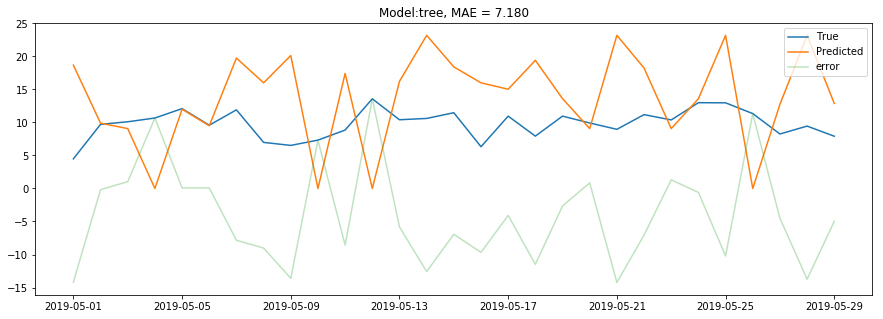

In [246]:
for model in models.items():
    model_to_chart(y=df_test.loc['2019-05-01':'2019-05-29'].values.ravel(), 
                y_pred= predicted_values.iloc[-30:-1][model[0]].values, 
                index = predicted_values.iloc[-30:-1].index, 
                model_name=model[0])

#### Do you remember that we have used the Box-Cox transformation?
#### It is time to reverse!

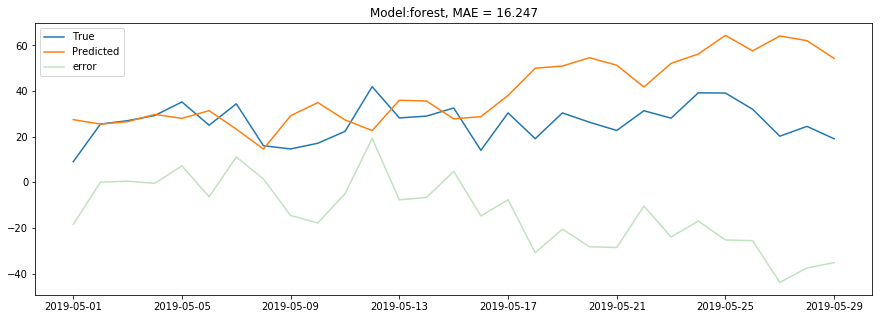

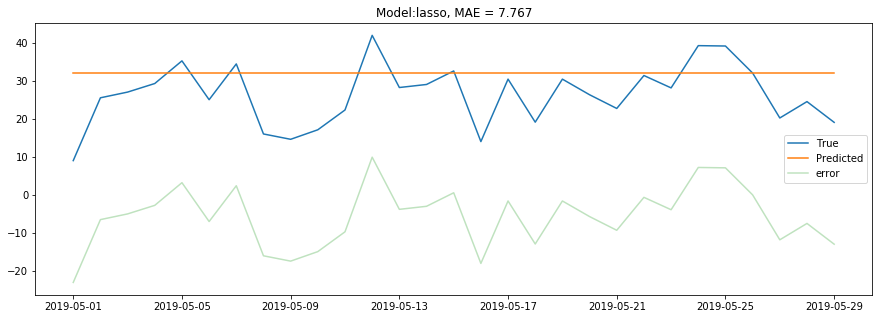

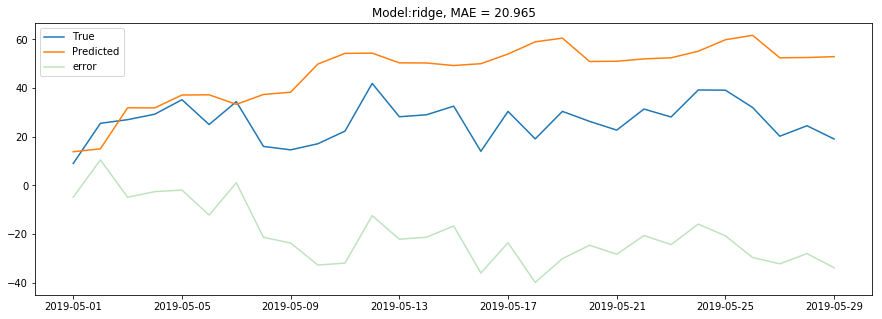

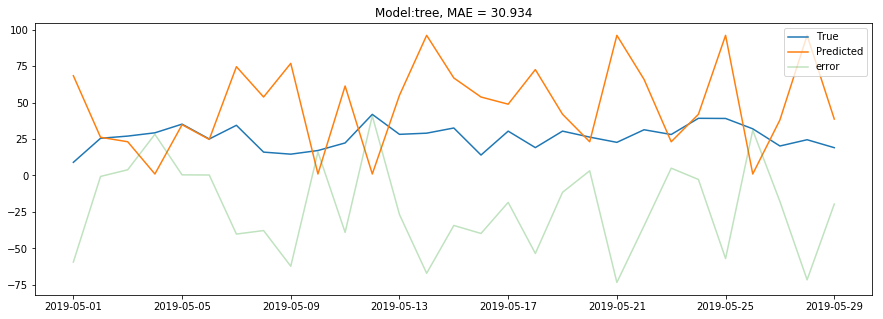

In [248]:
df_test = inv_boxcox(df_test, fitted_lambda)
predicted_values = inv_boxcox(predicted_values, fitted_lambda)

for model in models.items():
    model_to_chart(y=df_test.loc['2019-05-01':'2019-05-29'].values.ravel(), 
                y_pred= predicted_values.iloc[-30:-1][model[0]].values, 
                index = predicted_values.iloc[-30:-1].index, 
                model_name=model[0])